In [1]:
import geopandas
import starepandas
import pystare
import numpy
import matplotlib.pyplot as plt
import pickle
import pandas
import glob

In [2]:
# We set level to 15 because that appears to be matching VNP02 nadir resolution 
level = 15
country = 'Dominica'

In [3]:
adm2 = pandas.read_pickle('covers/caribbean_staredf_l{}.pickle'.format(level))

In [4]:
adm0 = pandas.read_pickle('covers/countries_staredf_l{}.pickle'.format(level))

In [5]:
df = geopandas.GeoDataFrame(adm2[adm2['ADM0_NAME']==country])

In [94]:
cover_sids = adm0[adm0['ADM0_NAME']==country]['stare'].iloc[0]

<AxesSubplot:>

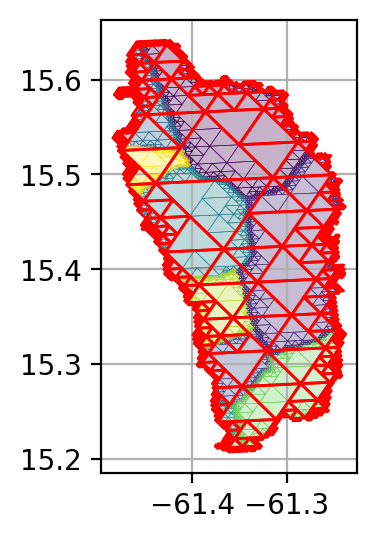

In [7]:
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.grid(True)

adm2[adm2['ADM0_NAME']==country].plot(ax=ax, trixels=False,  alpha=0.3, column='ADM2_CODE')
adm2[adm2['ADM0_NAME']==country].plot(ax=ax, trixels=True, boundary=True, linewidth=0.2, column='ADM2_CODE')
adm0[adm0['ADM0_NAME']==country].plot(ax=ax, trixels=True, color='red', linewidth=1)

#d.plot(ax=ax, linewidth=0.2, column='ADM2_CODE')

# Load catalog and find intersecting granules

In [100]:
catalog_vj103 = pandas.read_pickle('catalogs/vj103.pickle')

In [102]:
intersects = catalog_vj103.stare_intersects(cover_sids, n_workers=50)
intersecting = catalog_vj103[intersects]
intersecting.head()

,begining,ending,granule_path,sidecar_path,stare_cover
0,2019-06-23T06:42:00.000Z,2019-06-23T06:48:00.000Z,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20191...,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20191...,"[2485986994308513795, 3098476543630901251, 250..."
1,2019-04-28T05:54:00.000Z,2019-04-28T06:00:00.000Z,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20191...,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20191...,"[2485986994308513795, 2499497793190625284, 250..."
6,2019-06-27T05:24:00.000Z,2019-06-27T05:30:00.000Z,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20191...,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20191...,"[2504001392817995779, 2576058986855923715, 245..."
13,2019-01-27T06:00:00.000Z,2019-01-27T06:06:00.000Z,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20190...,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20190...,"[2485986994308513795, 2499497793190625284, 250..."
22,2020-05-01T05:36:00.000Z,2020-05-01T05:42:00.000Z,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20201...,/tablespace/caribbean/VJ103DNB/VJ103DNB.A20201...,"[2485986994308513795, 2756202971950743555, 249..."


# Read Granule

In [35]:
n = 2
geoloc_path = intersecting.iloc[n].granule_path
begining = intersecting.iloc[n].begining
ending = intersecting.iloc[n].ending

granule_path = starepandas.guess_companion_path(geoloc_path, 
                                                prefix='VJ102DNB',
                                                folder='/tablespace/caribbean/VJ102DNB/')


print(geoloc_path)
print(granule_path)

/tablespace/caribbean/VJ103DNB/VJ103DNB.A2019178.0524.002.2019214233806.nc
/tablespace/caribbean/VJ102DNB/VJ102DNB.A2019178.0524.002.2019215003530.nc


In [36]:
vj102 = starepandas.read_granule(granule_path, sidecar=False, read_latlon=False)
vj103 = starepandas.read_granule(geoloc_path, sidecar=True, read_latlon=True)

In [37]:
vj102 = vj102.join(vj103)
vj102.head()

,DNB_observations,DNB_quality_flags,lat,lon,stare,moon_illumination_fraction,land_water_mask,quality_flag
0,-9.999000e+02,256,36.337189,-70.626106,3150734463347273102,32.329998,7,0
1,4.277262e-10,16,36.337070,-70.617180,3150734544318077774,32.329998,7,0
2,-1.488355e-09,16,36.336956,-70.608261,3150734523872161614,32.329998,7,0
3,-1.388486e-09,16,36.336834,-70.599350,3150735971433439406,32.329998,7,0
4,8.477707e-11,16,36.336720,-70.590446,3150735974988617198,32.329998,7,0


# Filter according to masks and flags

## DNB_quality_flags
- 1     Substitute_Cal 
- 2     Out_of_Range 
- 4     Saturation 
- 8     Temp_not_Nominal 
- 16    Stray_light 
- 256   Bowtie_Deleted 
- 512   Missing_EV 
- 1024  Cal_Fail 
- 2048  Dead_Detector

## land_water_mask
- 0 Shallow Ocean; Ocean pixel with depth < 160 ft
- 1 Land; Land detected
- 2 Shoreline; Last land pixel before water
- 3 Inland Water;  Open surface water on continent
- 4 Ephemeral Water; Not populated in this version
- 5 Deep Inland Water; Inland water > 160 ft
- 6 Moderate Ocean; Ocean pixel with depth > 160 ft but <400 ft
- 7 Deep Ocean; Ocean pixel with depth > 400 ft

## quality_flag (geolocation)
- 1: Input_invalid
- 2: Pointing_bad
- 3: Terrain_bad

In [38]:
mask = vj102['DNB_quality_flags'] == 0
mask &= vj102['quality_flag'] == 0
mask &= (vj102['land_water_mask'] == 1) | (vj102['land_water_mask'] == 2)

In [39]:
selected = vj102[mask]
print('{} %'.format(round(selected.size/vj102.size*100)))

1 %


# Pulling out data intersecting our Country

In [40]:
intersects = selected.stare_intersects(cover_sids, n_workers=10)
intersected = selected[intersects.values]
intersected.head()

,DNB_observations,DNB_quality_flags,lat,lon,stare,moon_illumination_fraction,land_water_mask,quality_flag
12238222,2.588784e-10,0,15.637467,-61.428001,2521991335828447150,32.079998,2,0
12238223,2.768222e-10,0,15.636485,-61.421261,2521990306577975374,32.079998,2,0
12242282,6.924331e-10,0,15.634843,-61.456982,2521990227800405006,32.079998,2,0
12242283,2.112181e-10,0,15.633789,-61.449745,2521990235091959534,32.079998,2,0
12242284,2.102946e-10,0,15.632711,-61.442326,2521990257648434894,32.079998,1,0


In [88]:
intersected[2:10].set_index('stare').drop(columns=['DNB_quality_flags', 
                                                   'geometry', 
                                                   'moon_illumination_fraction', 
                                                   'quality_flag',
                                                   'land_water_mask']).head()

,DNB_observations,lat,lon
stare,,,
2521990227800405006,6.924331e-10,15.634843,-61.456982
2521990235091959534,2.112181e-10,15.633789,-61.449745
2521990257648434894,2.102946e-10,15.632711,-61.442326
2521990250564846286,2.186060e-10,15.631692,-61.435333
2521990342894879886,3.815961e-10,15.630707,-61.428555


<AxesSubplot:>

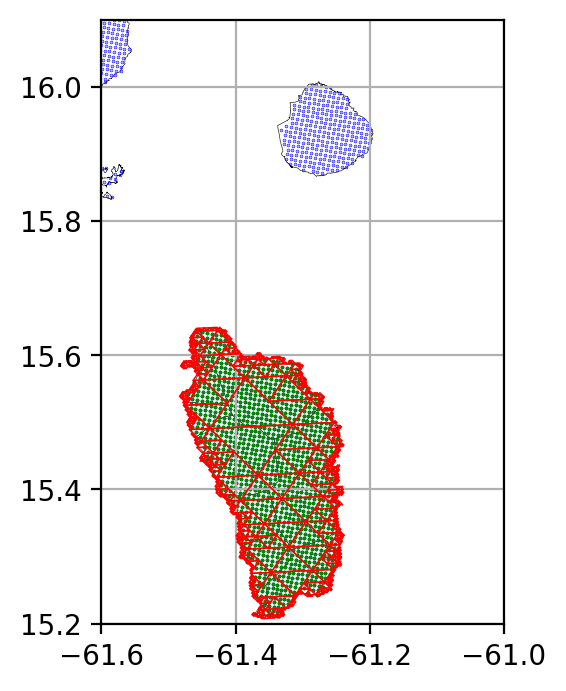

In [83]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
ax.grid(True)

ax.set_ylim(15.2, 16.1)
ax.set_xlim(-61.6, -61)

pts = geopandas.points_from_xy(selected.lon, selected.lat)
selected = selected.set_geometry(pts)

intersected = selected[intersects.values]

adm0[adm0['ADM0_NAME']==country].plot(ax=ax, trixels=True, color='red', linewidth=0.5)
adm2.plot(ax=ax, trixels=False, edgecolor='black', color='white', linewidth=0.2)
selected.plot(ax=ax, color='b', alpha=1, marker='.', markersize=0.2)
intersected.plot(ax=ax, color='g', alpha=1, markersize=0.2)

# Now we get the value per ADM2

In [ ]:
db_path = 'timeseries.sqlite' 
uri = 'sqlite:///{db_path}'.format(db_path=db_path)
engine = sqlalchemy.create_engine(uri)

In [17]:
adm2_country = adm2[adm2['ADM0_NAME']==country]

df = pandas.DataFrame()
for index, row in adm2_country.iterrows():        
    in_adm2 = intersected.stare_intersects(row.stare)
    mean = intersected[in_adm2.values].mean()    
    df = df.append({'start': begining, 
                    'adm0': row.ADM0_CODE,
                    'adm2': row.ADM2_CODE, 
                    'avg_dnb': mean['DNB_observations'],
                    'moon': mean['moon_illumination_fraction']}, ignore_index=True)
    
df.to_sql(name='dnb_noaa20', con=engine, if_exists='append', index=False)

,adm0,adm2,avg_dnb,moon,start
0,71.0,15283.0,5.057491e-10,37.163876,2019-04-28T05:54:00.000Z
1,71.0,15285.0,1.820799e-09,37.159996,2019-04-28T05:54:00.000Z
2,71.0,15286.0,8.827996e-10,37.162670,2019-04-28T05:54:00.000Z
3,71.0,15287.0,4.645342e-10,37.160000,2019-04-28T05:54:00.000Z
4,71.0,15288.0,1.352276e-09,37.160000,2019-04-28T05:54:00.000Z
5,71.0,15289.0,7.003007e-10,37.160000,2019-04-28T05:54:00.000Z
6,71.0,15290.0,6.472944e-10,37.160000,2019-04-28T05:54:00.000Z
7,71.0,15291.0,1.080778e-09,37.160000,2019-04-28T05:54:00.000Z
8,71.0,15292.0,3.935273e-10,37.160004,2019-04-28T05:54:00.000Z
9,71.0,15284.0,5.396370e-10,37.160000,2019-04-28T05:54:00.000Z


# Load Cloudmask

In [18]:
catalog_cldmsk_noaa_20 = pandas.read_pickle('catalogs/cldmsk_noaa20.pickle')

In [19]:
intersects = catalog_cldmsk_noaa_20.stare_intersects(cover_sids, n_workers=50)
intersecting = catalog_cldmsk_noaa_20[intersects]
intersecting.head()

,begining,ending,granule_path,sidecar_path,stare_cover
3,2019-11-17T05:48:00.000Z,2019-11-17T05:54:00.000Z,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,"[2485986994308513796, 2488238794122199044, 249..."
23,2020-04-11T05:06:00.000Z,2020-04-11T05:12:00.000Z,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,"[2576058986855923715, 2458965396544290820, 246..."
26,2019-07-31T04:48:00.000Z,2019-07-31T04:54:00.000Z,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,"[2494994193563254787, 2558044588346441731, 250..."
27,2020-01-03T06:06:00.000Z,2020-01-03T06:12:00.000Z,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,"[2485986994308513795, 2515260391886422020, 251..."
30,2019-06-18T06:36:00.000Z,2019-06-18T06:42:00.000Z,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/C...,"[3098476543630901251, 2485986994308513796, 249..."


In [20]:
n = 0
granule_path = intersecting.iloc[n].granule_path
begining = intersecting.iloc[n].begining
ending = intersecting.iloc[n].ending

geoloc_path = starepandas.guess_companion_path(granule_path, 
                                               prefix='VJ103MOD',
                                               folder='/tablespace/caribbean/VJ103MOD/')


print(granule_path)
print(geoloc_path)

/tablespace/caribbean/VJ103MOD/VJ103MOD.A2019321.0548.002.2019321105549.nc
/tablespace/caribbean/CLDMSK_L2_VIIRS_NOAA20/CLDMSK_L2_VIIRS_NOAA20.A2019321.0548.001.2020295002710.nc


In [91]:
cldmsk = starepandas.read_granule(granule_path, sidecar=True, read_latlon=False)
vj103mod = starepandas.read_granule(geoloc_path, sidecar=False, read_latlon=True)

In [22]:
cldmsk = cldmsk.join(vj103mod)
cldmsk.head()

,stare,Integer_Cloud_Mask,lat,lon,land_water_mask,quality_flag
0,3104682540721440557,0,18.176790,-77.395836,1,0
1,3104682552099202253,1,18.175446,-77.380562,1,0
2,3104682729724359564,2,18.173943,-77.363678,1,0
3,3104682696911741325,2,18.172546,-77.347771,1,0
4,3104407385763144493,2,18.171181,-77.332489,1,0


## Cloud mask meaning
- 0 = cloudy
- 1 = probably cloudy 
- 2 = probably clear 
- 3 = confident clear
- -1 = no result

## quality_flag (geolocation)
- 1: Input_invalid
- 2: Pointing_bad
- 3: Terrain_bad

## Cloud Mask QA (1km) 
- Bit 1: 0 not useful; 1 useful. 
- Bit 2-7: confidence levels

i.e. 0 is bad. All other probably good.

In [23]:
mask = cldmsk['quality_flag'] == 0
mask &= (cldmsk['land_water_mask'] == 1) | (cldmsk['land_water_mask'] == 2)

In [24]:
selected = cldmsk[mask]
print('{} %'.format(round(selected.size/cldmsk.size*100)))

63 %


In [25]:
intersects = selected.stare_intersects(cover_sids, n_workers=10)
intersected = selected[intersects.values]
intersected.head()

,stare,Integer_Cloud_Mask,lat,lon,land_water_mask,quality_flag
232265,2521991331142512078,1,15.636530,-61.445705,2,0
232266,2521990248884337806,2,15.635283,-61.438221,2,0
232267,2521990246303043182,2,15.634013,-61.430550,2,0
232268,2521990340440878126,2,15.632705,-61.422771,1,0
235463,2521894434202212334,0,15.632225,-61.461914,2,0


<AxesSubplot:>

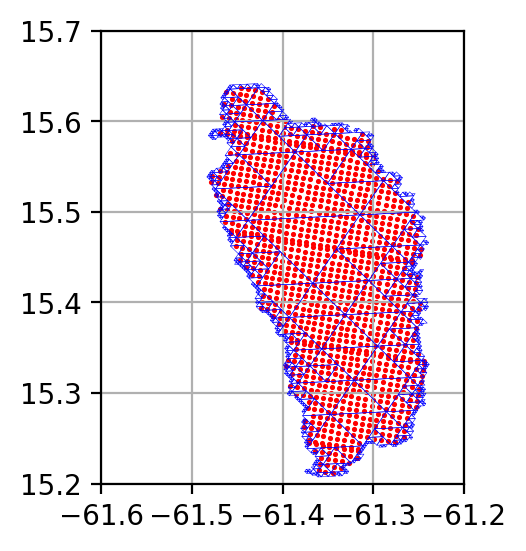

In [26]:
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.grid(True)

ax.set_ylim(15.2, 15.7)
ax.set_xlim(-61.6, -61.2)

pts = geopandas.points_from_xy(intersected.lon, intersected.lat)
intersected = intersected.set_geometry(pts)

adm0[adm0['ADM0_NAME']==country].plot(ax=ax, trixels=True, color='b', linewidth=0.2)
intersected.plot(ax=ax, color='r', alpha=1, marker='.', markersize=3)

In [27]:
adm2_country = adm2[adm2['ADM0_NAME']==country]

df = pandas.DataFrame()
for index, row in adm2_country.iterrows():        
    in_adm2 = intersected.stare_intersects(row.stare)
    mean = intersected[in_adm2.values].mean()    
    df = df.append({'start': begining, 
                    'adm0': row.ADM0_CODE,
                    'adm2': row.ADM2_CODE, 
                    'avg_dnb': mean['Integer_Cloud_Mask']}, ignore_index=True)
    
df

,adm0,adm2,avg_dnb,start
0,71.0,15283.0,0.939799,2019-11-17T05:48:00.000Z
1,71.0,15285.0,1.765432,2019-11-17T05:48:00.000Z
2,71.0,15286.0,0.482353,2019-11-17T05:48:00.000Z
3,71.0,15287.0,1.058824,2019-11-17T05:48:00.000Z
4,71.0,15288.0,2.428571,2019-11-17T05:48:00.000Z
5,71.0,15289.0,2.000000,2019-11-17T05:48:00.000Z
6,71.0,15290.0,1.634483,2019-11-17T05:48:00.000Z
7,71.0,15291.0,1.333333,2019-11-17T05:48:00.000Z
8,71.0,15292.0,1.770833,2019-11-17T05:48:00.000Z
9,71.0,15284.0,0.080745,2019-11-17T05:48:00.000Z
